In [44]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

Use monthly number of EVs to predict distribution of other vehicle types

**Load data**

In [38]:
fuel_types = ['electric','plug-in hybrid electric','fuel cell','diesel','flex fuel','gasoline','gasoline hybrid','natural gas','propane']

# CA hourly CO2 emissions and demand

df = pd.read_csv('data/monthly_all_data.csv')
df.drop(['Unnamed: 0','emissions','demand','date'], axis=1, inplace=True)

print(f"shape: {df.shape}")
df.head()

shape: (96, 10)


,date_idx,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas,propane
0,95,522436,305309,10117,590218,1208964,25998612,1298265,8456,93
1,94,509680,301459,9868,599397,1203595,25917176,1286366,8391,160
2,93,496924,297609,9619,608576,1198226,25835740,1274467,8326,227
3,92,484168,293759,9370,617755,1192857,25754304,1262568,8261,294
4,91,471412,289909,9121,626934,1187488,25672868,1250669,8196,361


**Correlation**

<AxesSubplot: >

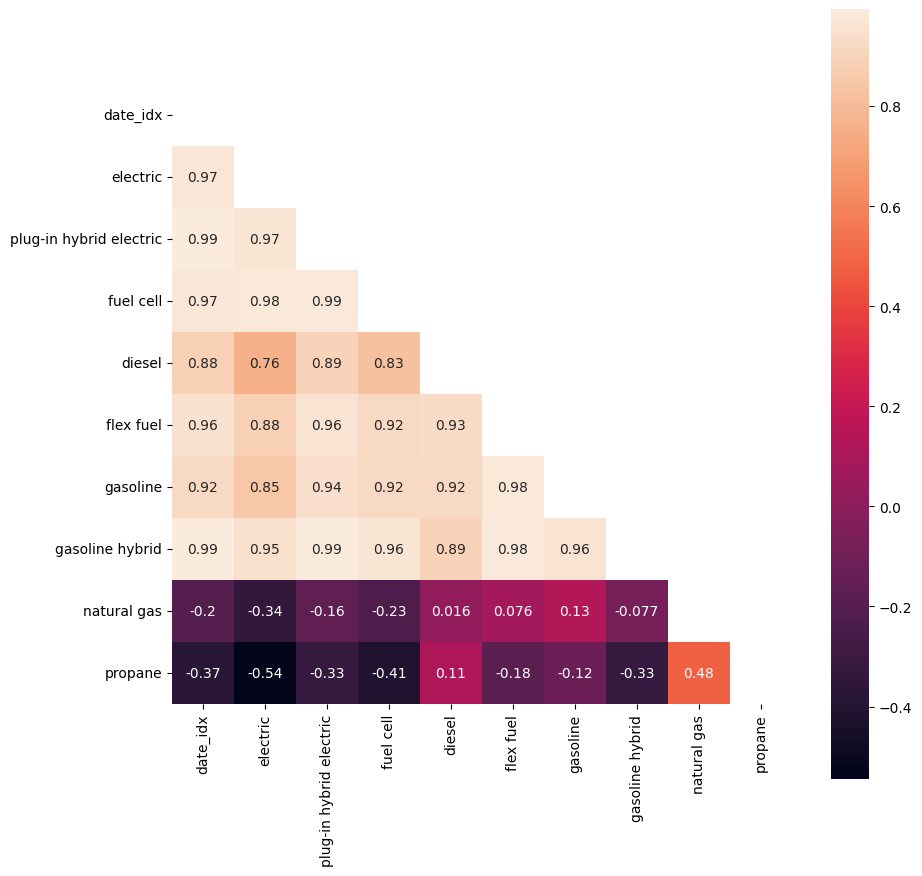

In [39]:
correlation = df.corr(method = 'pearson')
plt.subplots(figsize = (10,10))
masked = np.triu(np.ones_like(correlation, dtype=bool)) 
sns.heatmap(correlation,mask=masked,square = True, annot = True)

**Linear regression**

In [76]:
# disregard propane as its quantity is negligible and natural gas due to it staying stable over time
for fuel in fuel_types:
  if fuel != 'electric' and fuel != 'propane' and fuel != 'natural gas':
    X = df["electric"]
    y = df[fuel]

    slope, intercept, r, p, std_err = stats.linregress(X, y)

    def lin_func(X):
      return slope * X + intercept

    print(f'Electric and {fuel} correlation coefficient: {r}')

Electric and plug-in hybrid electric correlation coefficient: 0.9662769023657738
Electric and fuel cell correlation coefficient: 0.9785768553458403
Electric and diesel correlation coefficient: 0.7620211811090198
Electric and flex fuel correlation coefficient: 0.8805838314622024
Electric and gasoline correlation coefficient: 0.8480094316667867
Electric and gasoline hybrid correlation coefficient: 0.9508255094485304


**Polynomial regression**

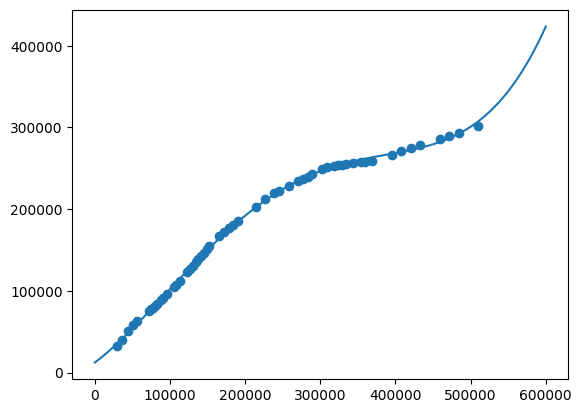

Electric and plug-in hybrid electric training data score: 0.9991929431131684; testing data score: 0.9987617139466805


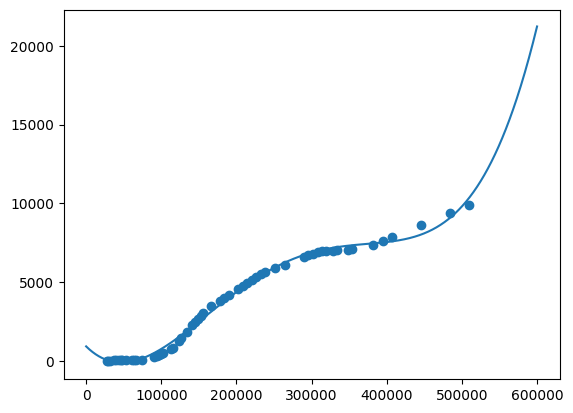

Electric and fuel cell training data score: 0.995205453066441; testing data score: 0.992286525168468


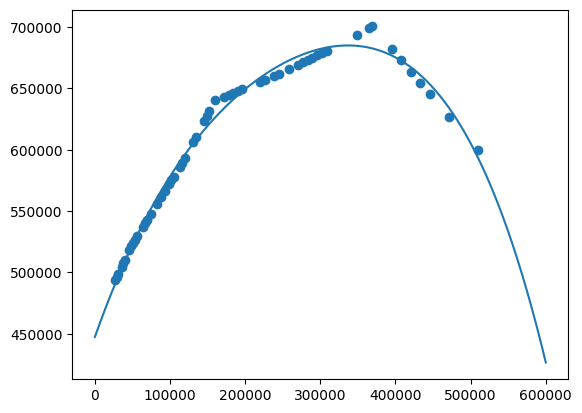

Electric and diesel training data score: 0.990559083620068; testing data score: 0.9893092336354984


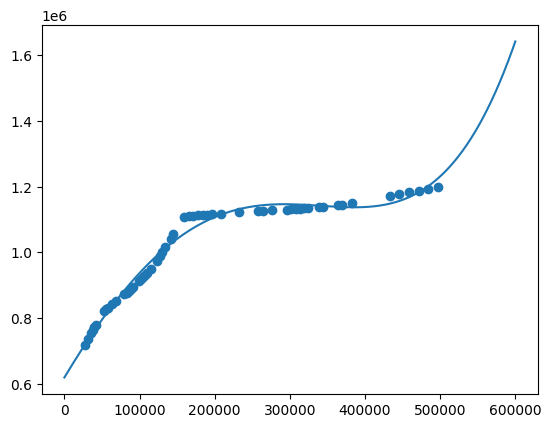

Electric and flex fuel training data score: 0.9839105946087241; testing data score: 0.977305472209994


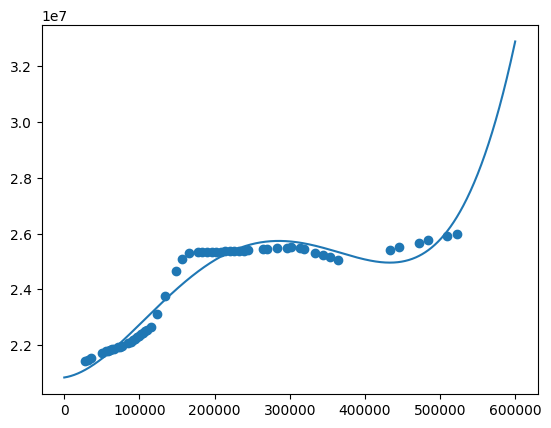

Electric and gasoline training data score: 0.95182416305266; testing data score: 0.9495025556630992


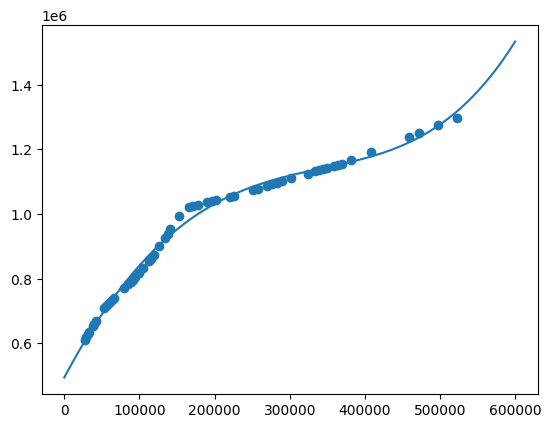

Electric and gasoline hybrid training data score: 0.9943982865376291; testing data score: 0.9918553656534436


In [83]:
for fuel in fuel_types:
    if fuel != 'electric' and fuel != 'propane' and fuel != 'natural gas':
        X = df["electric"]
        y = df[fuel]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

        poly_model = np.poly1d(np.polyfit(X_train, y_train, 4))

        poly_line = np.linspace(0, 600000, 1000)

        plt.scatter(X_train, y_train)
        plt.plot(poly_line, poly_model(poly_line))
        plt.show()

        print(f'Electric and {fuel} training data score: {r2_score(y_train, poly_model(X_train))}; testing data score: {r2_score(y_test, poly_model(X_test))}')

**Random forest**

In [73]:
models = {}

for fuel in fuel_types:
    if fuel != 'electric' and fuel != 'propane' and fuel != 'natural gas':
        y_removal_list = fuel_types.copy()
        y_removal_list.append('date_idx')
        y_removal_list.remove(fuel)

        X = df[['electric', 'date_idx']]
        y = df.drop(columns=y_removal_list)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        distribution = {
              'n_estimators': [5,10,20,50,100,150,200]
            }

        random_forest = RandomForestRegressor()

        rscv = RandomizedSearchCV(estimator = random_forest, param_distributions = distribution, n_iter=40)                      
        rscv.fit(X_train,  y_train)

        print(f'Electric and {fuel} training data score: {rscv.score(X_train,  y_train)}; testing data score: {rscv.score(X_test, y_test)}')

        models[fuel] = rscv

Electric and plug-in hybrid electric training data score: 0.9998803023464162; testing data score: 0.9994132949805268
Electric and fuel cell training data score: 0.9993936504666888; testing data score: 0.9983068699589847
Electric and diesel training data score: 0.9992764581829123; testing data score: 0.9961574899209452
Electric and flex fuel training data score: 0.9997705333127035; testing data score: 0.9975024798232104
Electric and gasoline training data score: 0.999606231050668; testing data score: 0.9973536166135188
Electric and gasoline hybrid training data score: 0.9997639225953701; testing data score: 0.9986279683239281


Not suitable for this kind of dataset